
## Chioma Nwuzi
## Wealthfront Project Assessment


In [1]:

# import relevant packages

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#!pip install git+https://github.com/scikit-optimize/scikit-optimize.git
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc

from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier



'/Users/chiomanwuzi'

In [2]:

#load in the full dataset
loan_data = pd.read_csv(str(os.getcwd()) + "/Downloads/loan_data.csv")

# basic column and columnn data type information
loan_data.info() 
# find the total numnber of missing values for each column
loan_data.isnull().sum() 
# drop the columns where all the values are missing
loan_data = loan_data.dropna(axis = 1, how = "all") 
loan_data.dtypes.value_counts() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  int64  
 1   loan_amnt               10000 non-null  int64  
 2   funded_amnt             10000 non-null  int64  
 3   term                    9524 non-null   object 
 4   int_rate                9524 non-null   float64
 5   installment             9524 non-null   float64
 6   emp_length              9119 non-null   object 
 7   home_ownership          9524 non-null   object 
 8   annual_inc              9524 non-null   float64
 9   loan_status             9524 non-null   object 
 10  purpose                 9524 non-null   object 
 11  addr_state              10000 non-null  object 
 12  dti                     9524 non-null   float64
 13  delinq_2yrs             9524 non-null   float64
 14  earliest_cr_line        9524 non-null  

float64    14
object      8
int64       3
Name: count, dtype: int64

## Data Wrangling and Exploratory Data Analysis 


In [3]:

#change int_rate_2 to type float - remove trailing "%"
loan_data["int_rate2"] = loan_data["int_rate2"].astype("string").str.strip("%")
loan_data["int_rate2"] = loan_data["int_rate2"].astype("float")


In [4]:

# change the earliest_cr_line into interpretable variable that represents the time between the first line 
# of credit and the current date (truncated to last complete month)

loan_data["earliest_cr_line"] = pd.to_datetime(loan_data["earliest_cr_line"], format = '%Y-%m-%d %H:%M:%S')
loan_data["days_since_earliest_credit"] = (datetime.today() - loan_data["earliest_cr_line"]).dt.days

loan_data = loan_data.drop("earliest_cr_line", axis = 1) # remove the original varianble for first credit line



In [5]:

# summary statistics of each column
loan_data.describe()

# the descriptive statistics show an error in the days since earliest credit - the minimum number of days in the column is negative . Since the earlist day for credit cannot be in the future,
# that value will be imputed using the median.
loan_data["days_since_earliest_credit"].idxmin()
loan_data["days_since_earliest_credit"][9708] = np.nan



In [6]:
#create temp dataframes to explore the catagorical/ordinal and non-categorical variables separately\

cat_data = loan_data.select_dtypes(include = "object")
num_data = loan_data.select_dtypes(exclude = "object")


<Axes: >

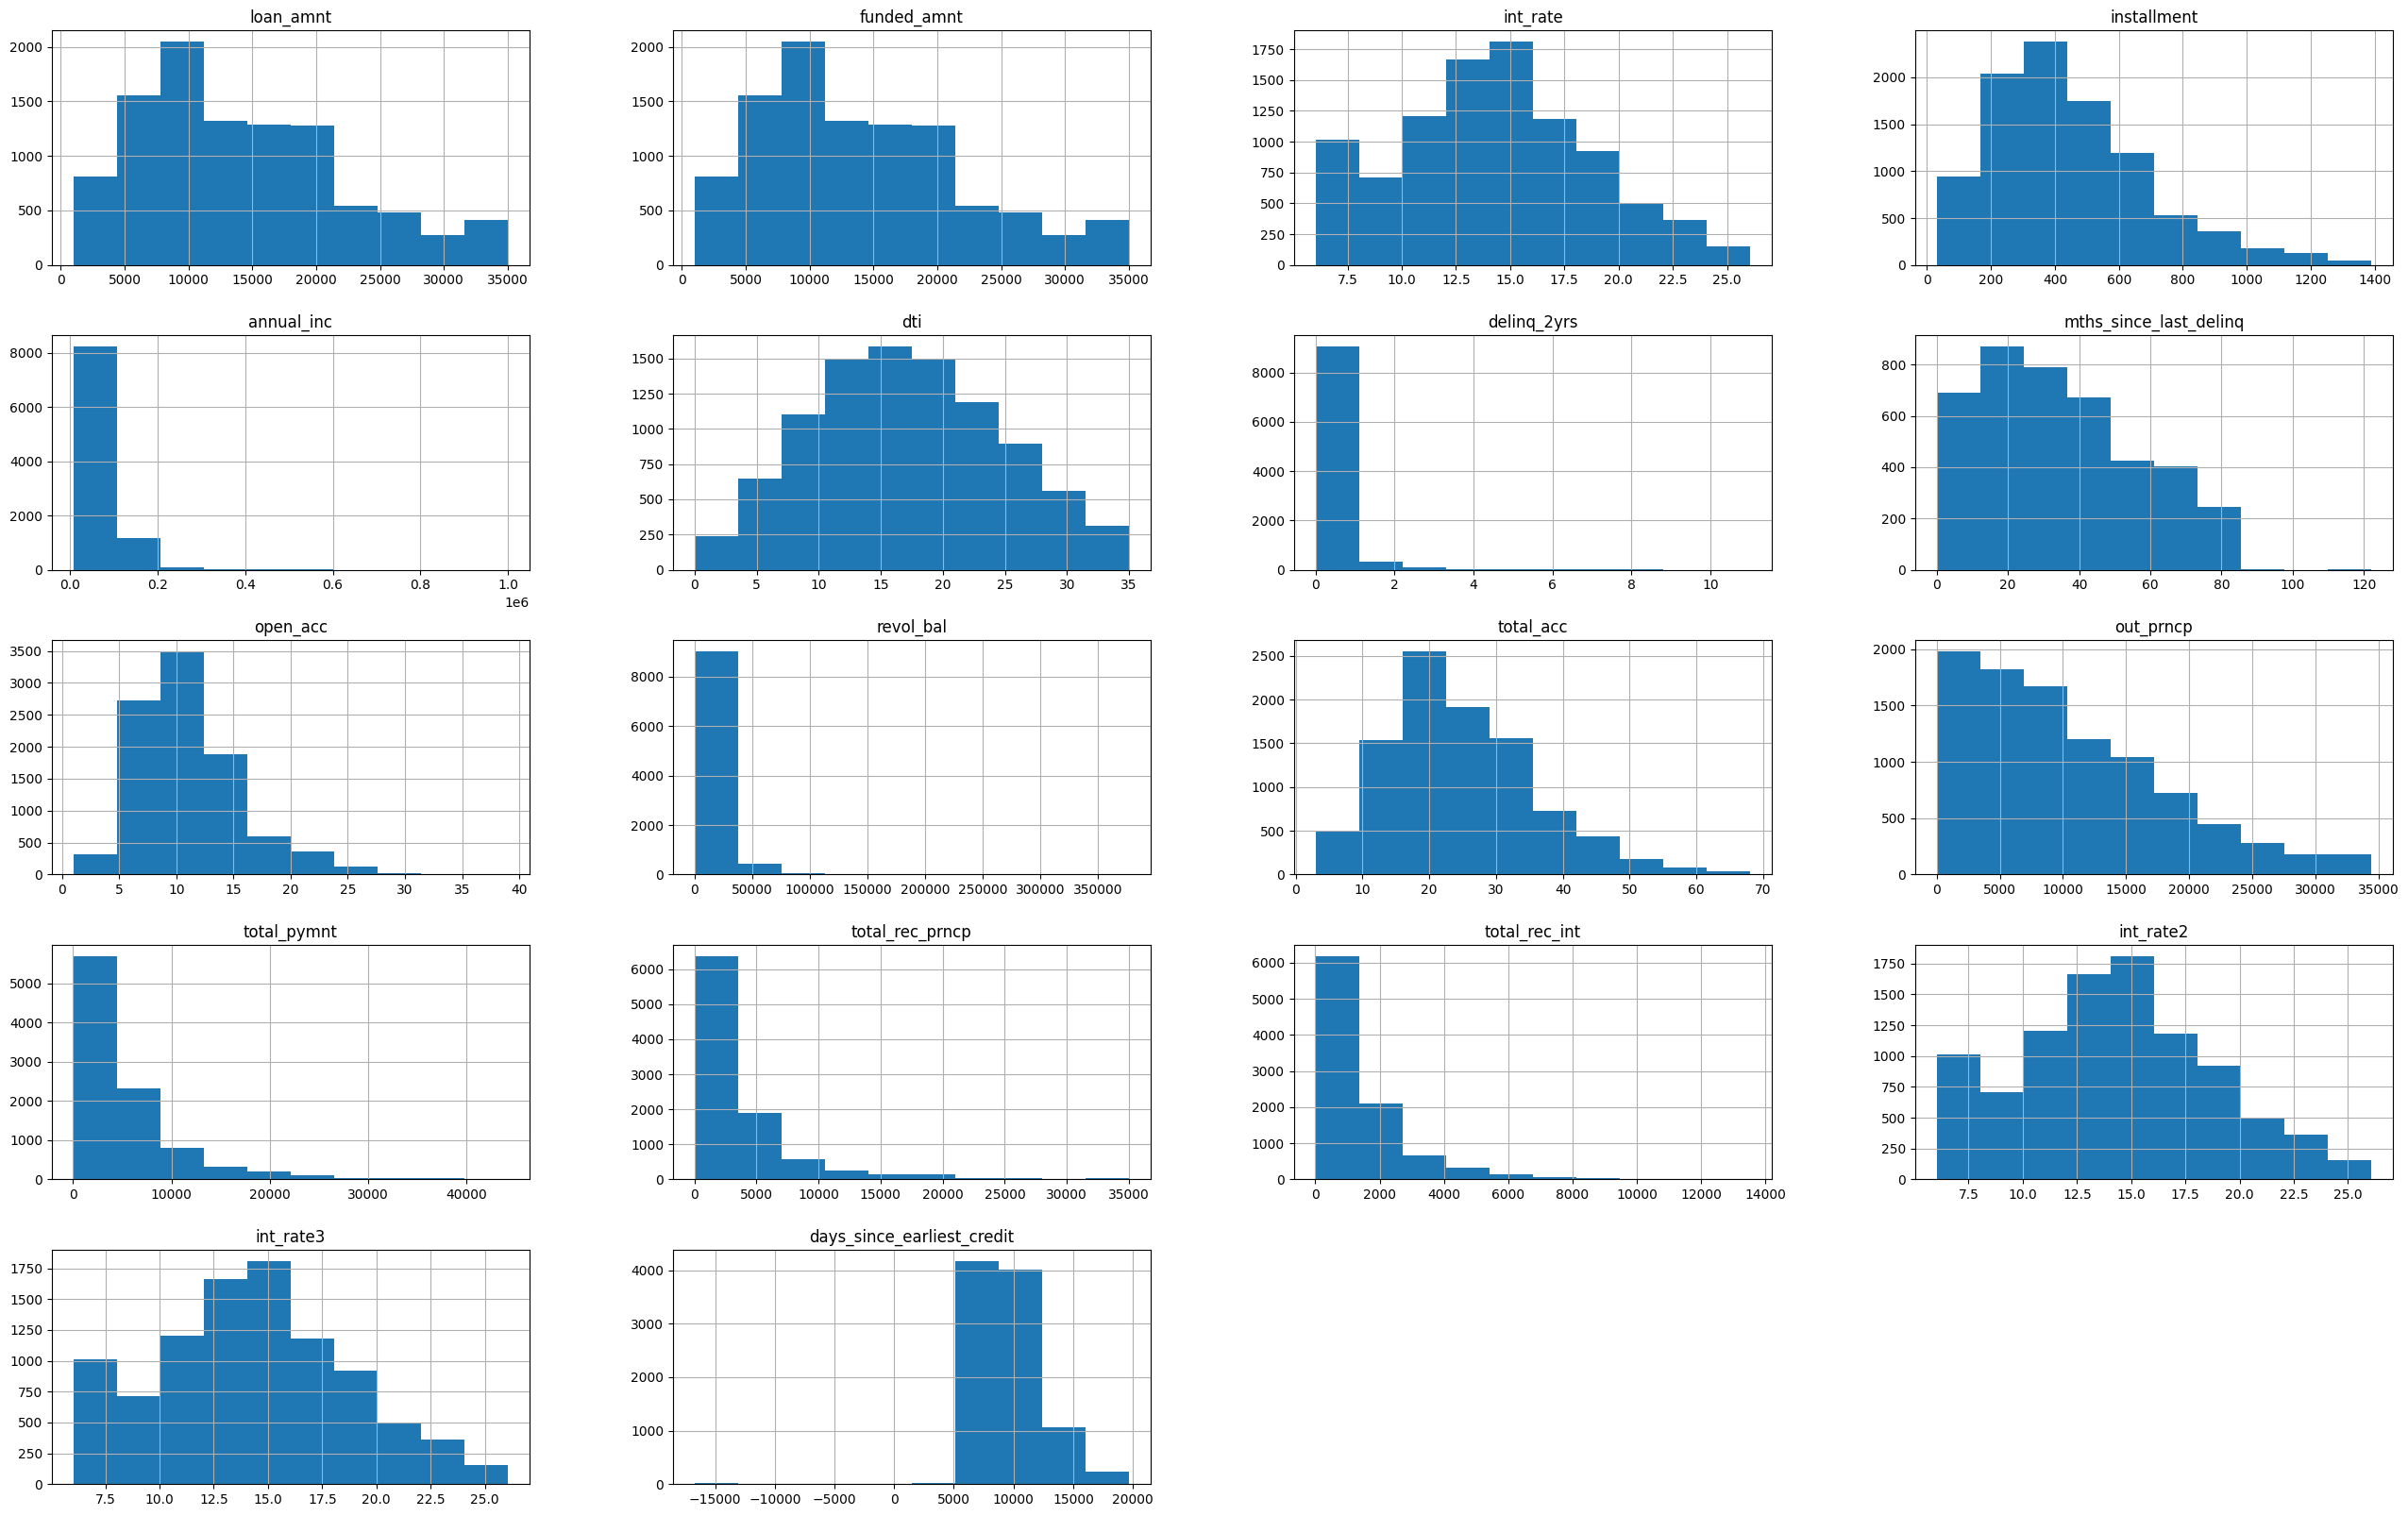

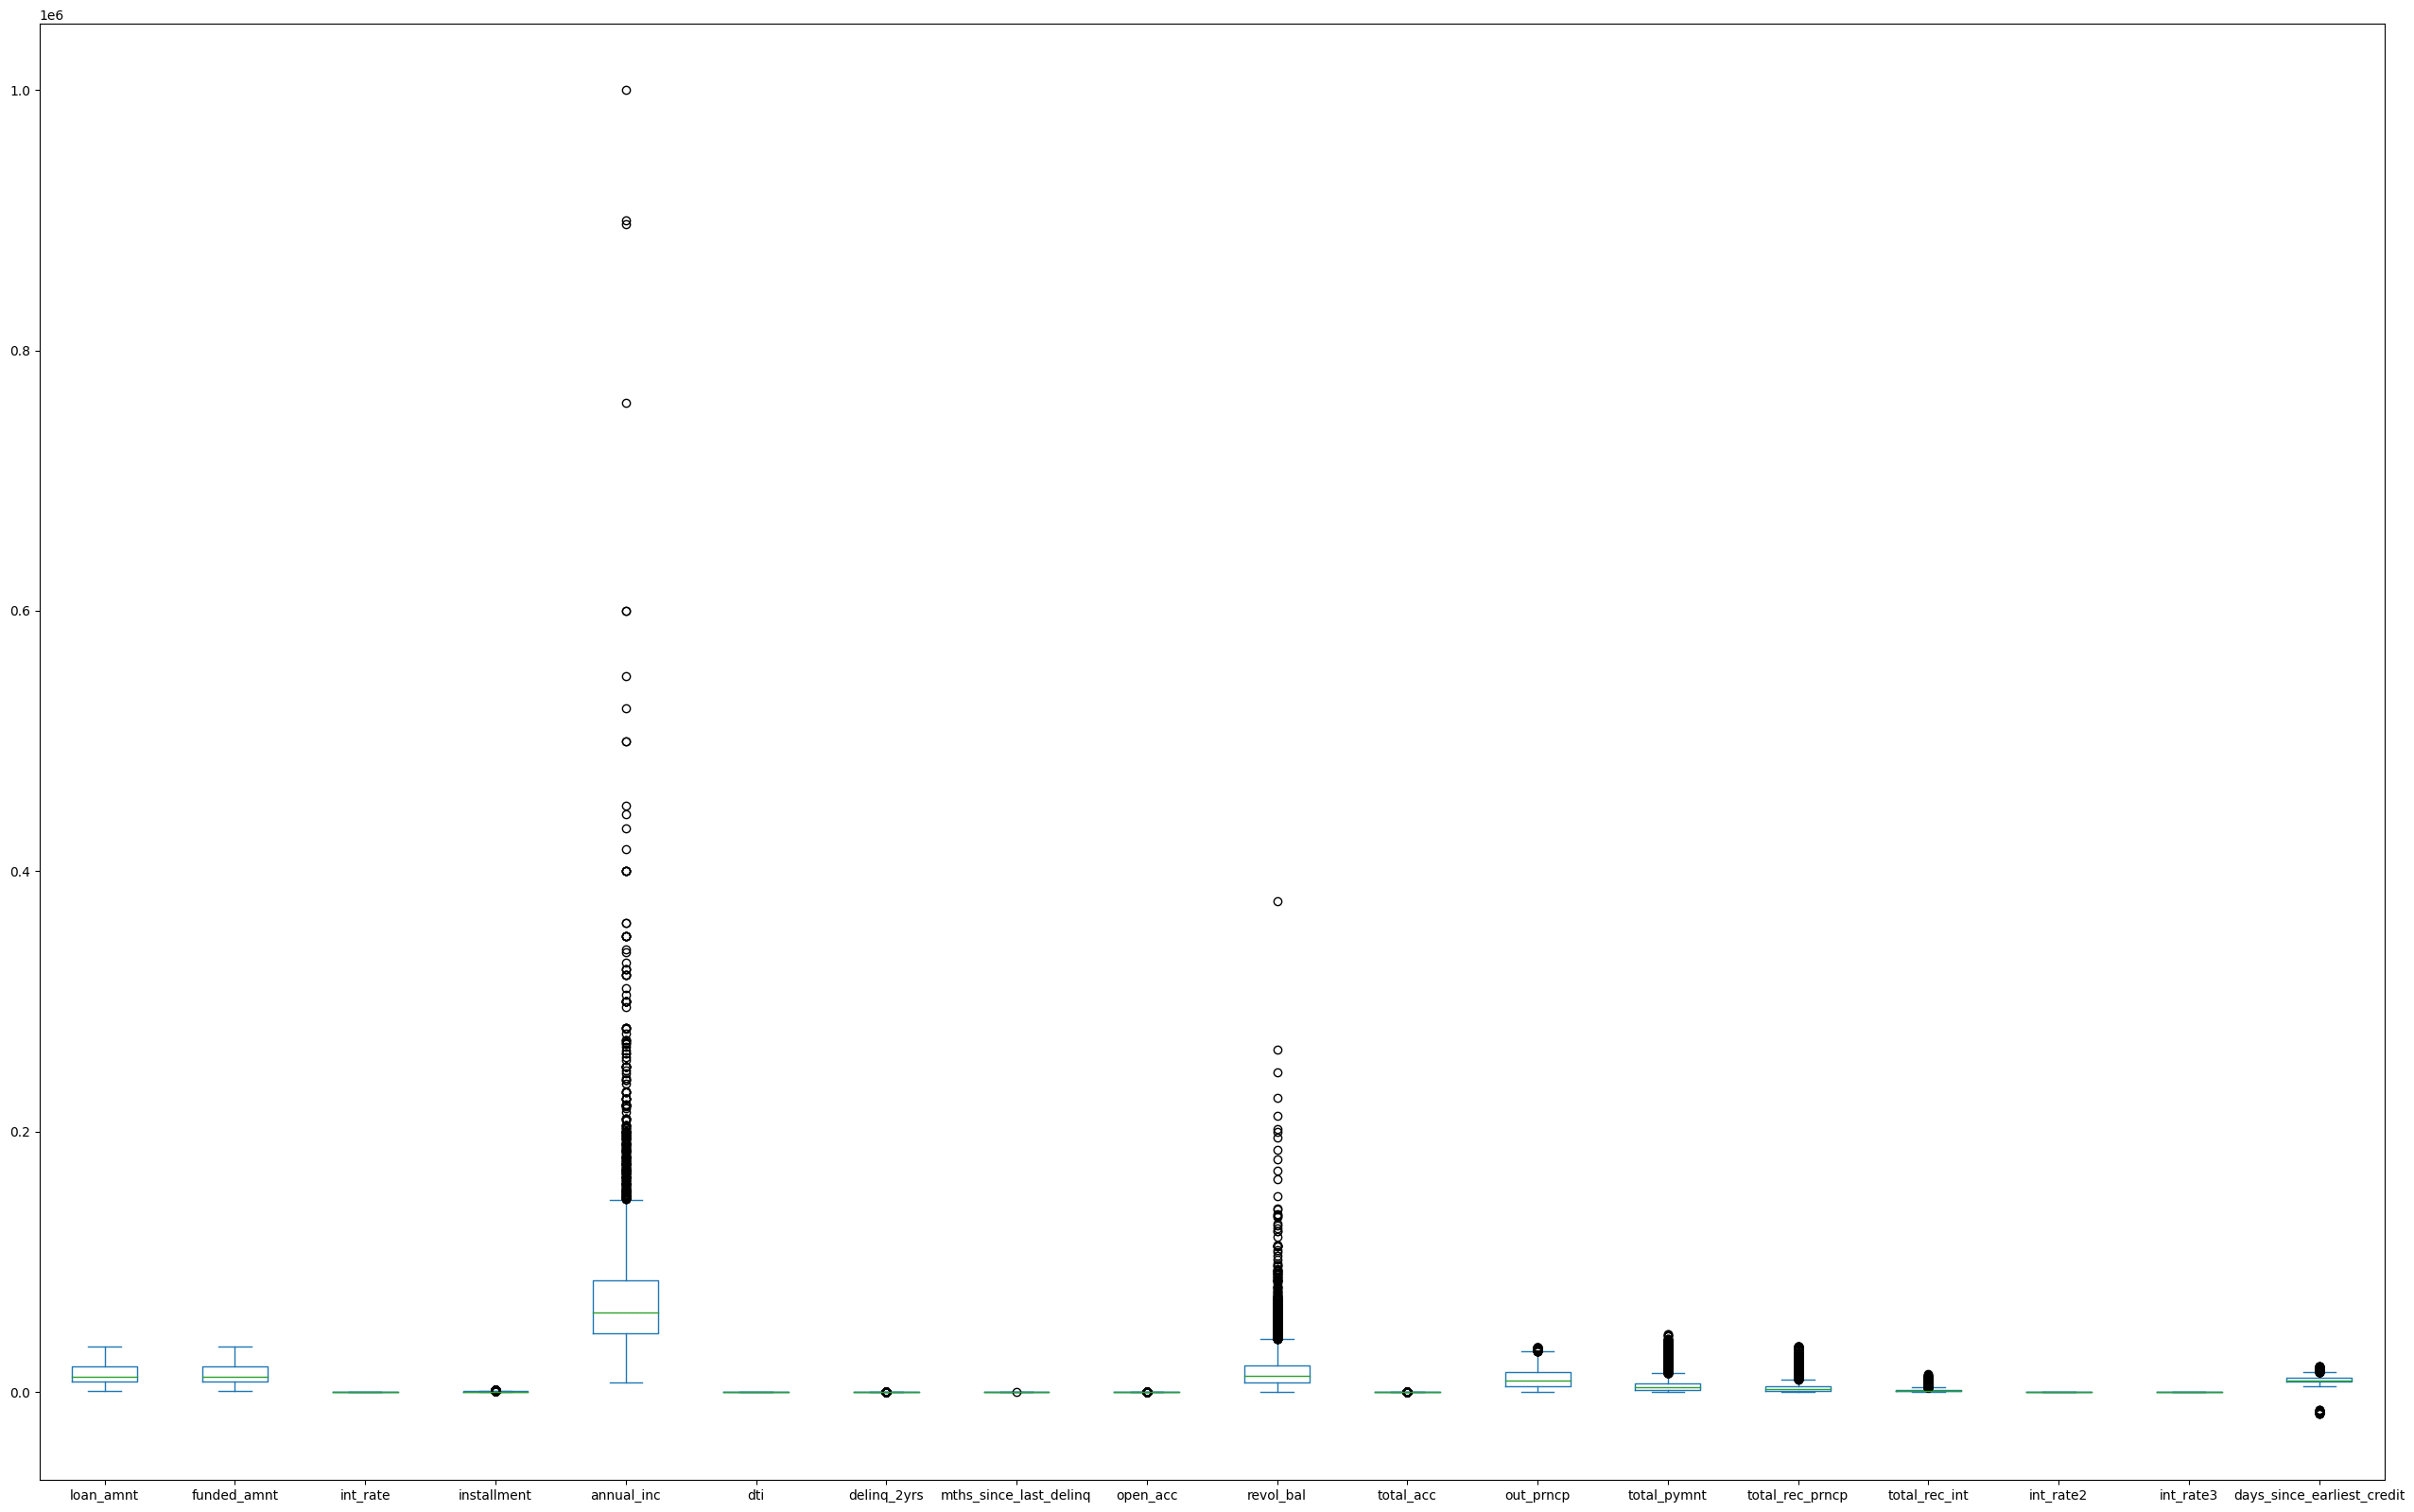

In [7]:

# plot the distibutions of the continuous variables 
num_data.iloc[:,1:].hist(figsize = (32,20))
num_data.iloc[:,1:].plot.box(figsize = (32,20))


#Most of the data appears to be approximately normal with the exception of annual inccome, delinquencies in the past 2 years, revolving balance, total payment, total rec prncp, total rec int, and days since earlist credit.
# The box plot shows obvious outliers in the annual income varible, revolving balance, total payment, total rec princ, total rec int, and days since earliest credit.

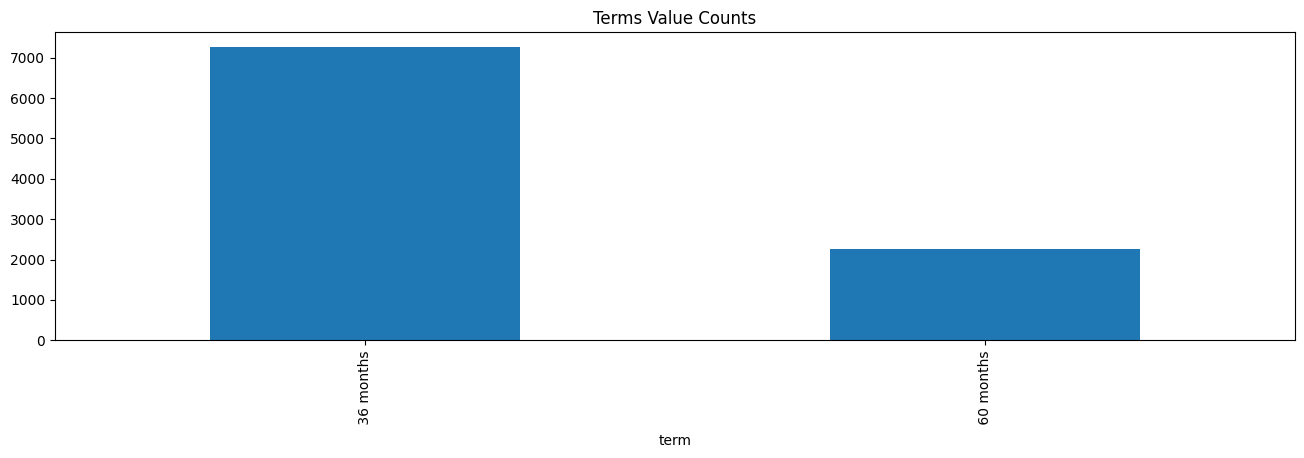

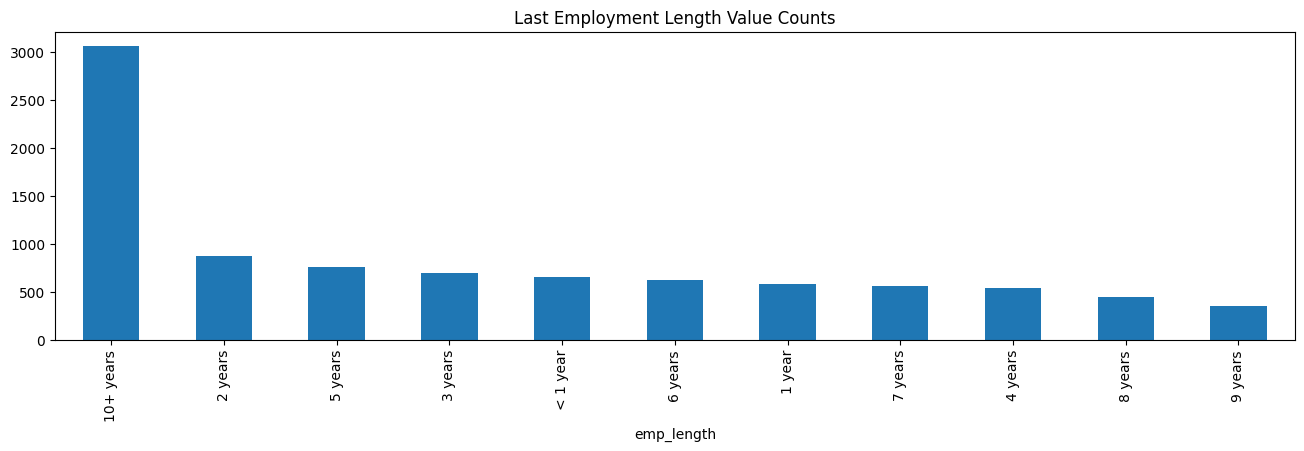

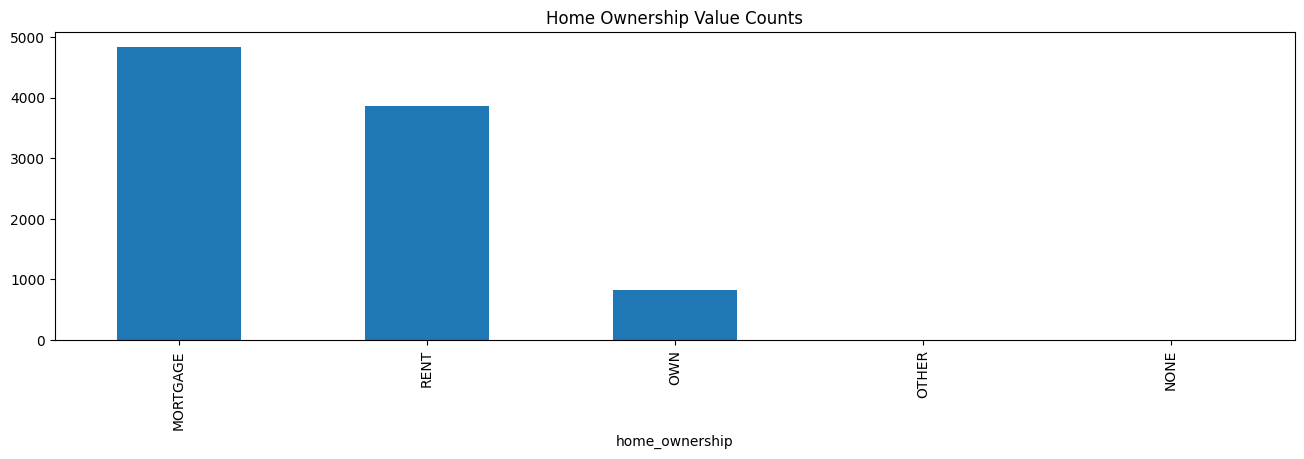

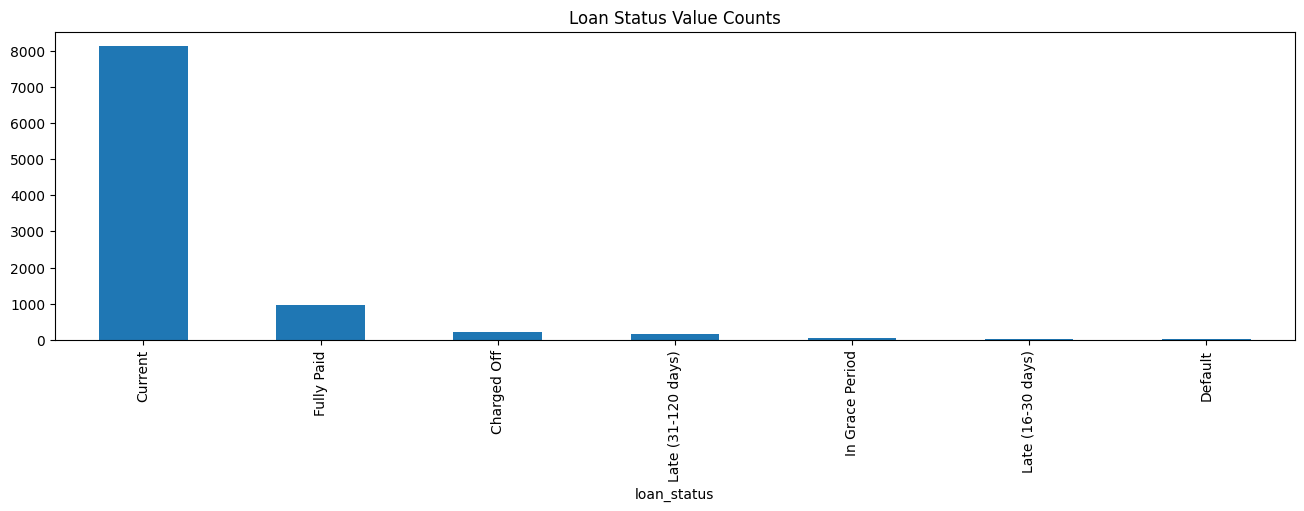

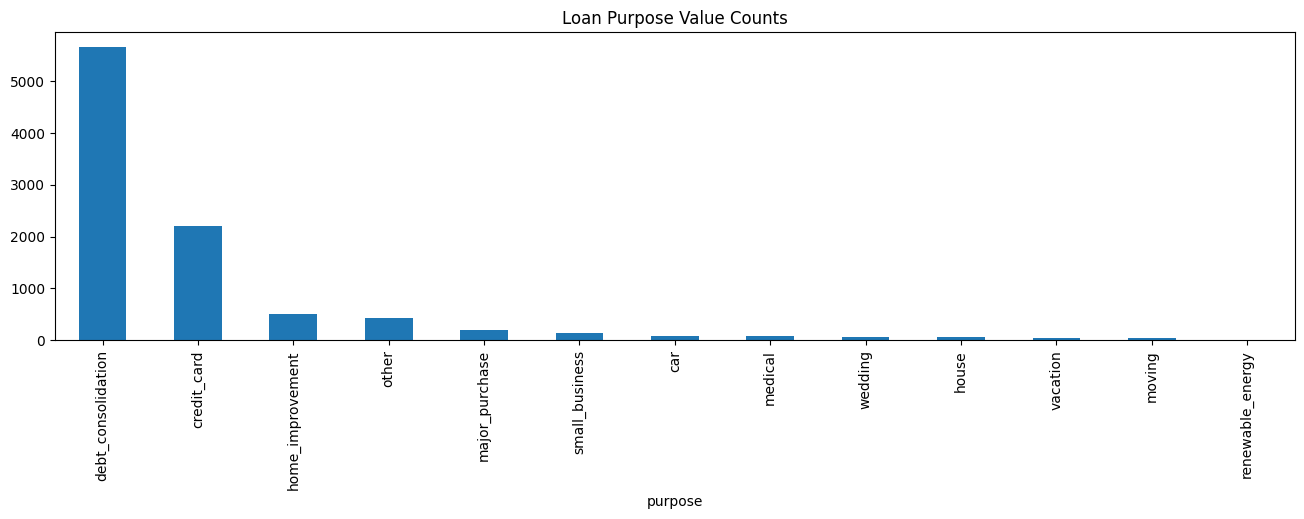

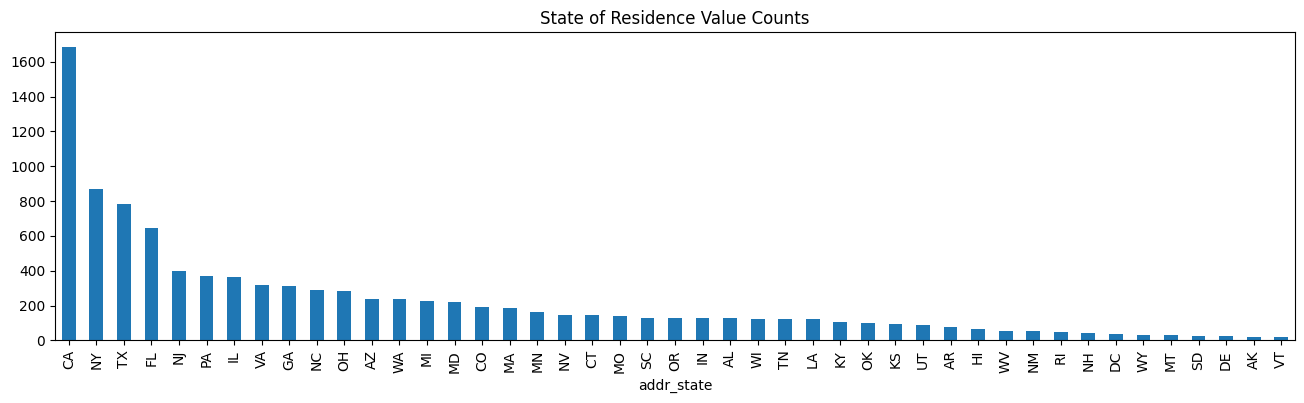

In [8]:

# plot catagorical variables

cat_data['term'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "Terms Value Counts")
plt.show()
cat_data['emp_length'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "Last Employment Length Value Counts")
plt.show()
cat_data['home_ownership'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "Home Ownership Value Counts")
plt.show()
cat_data['loan_status'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "Loan Status Value Counts")
plt.show()
cat_data['purpose'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "Loan Purpose Value Counts")
plt.show()
cat_data['addr_state'].value_counts(normalize = False).plot.bar(figsize = (16,4), title = "State of Residence Value Counts")
plt.show()




Correlation Analysis

If two variables are perfectly correlated or very close to being perfectly correlated, maintaing both variables in the dataset can lead to overfitting and inaccuracy model checking measures.

Loan amount and funded amount have a pearson correlation coefficient that is very close to 1 but not exactly one, so I will choose to keep it in the model.

,id,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,int_rate2,int_rate3,days_since_earliest_credit
id,1.000000,0.002759,0.003108,0.084055,0.026779,0.038028,0.016653,0.055196,-0.039933,0.052729,0.015213,0.065885,0.338055,-0.502419,-0.440630,-0.431603,0.084055,0.084055,0.008690
loan_amnt,0.002759,1.000000,0.999890,0.194150,0.956284,0.420569,0.035458,0.028281,-0.058921,0.189288,0.388866,0.236388,0.797781,0.474905,0.349848,0.625159,0.194150,0.194150,0.168477
funded_amnt,0.003108,0.999890,1.000000,0.194122,0.956418,0.420361,0.035450,0.028103,-0.058772,0.189276,0.388776,0.236385,0.798063,0.474841,0.349813,0.625036,0.194122,0.194122,0.168479
int_rate,0.084055,0.194150,0.194122,1.000000,0.173167,-0.017488,0.139869,0.121289,-0.078527,0.009860,-0.004953,-0.017181,0.204750,0.076154,-0.041361,0.413477,1.000000,1.000000,-0.076432
installment,0.026779,0.956284,0.956418,0.173167,1.000000,0.423918,0.030730,0.038015,-0.057899,0.185799,0.377170,0.218655,0.733059,0.491528,0.381716,0.583563,0.173167,0.173167,0.153951
annual_inc,0.038028,0.420569,0.420361,-0.017488,0.423918,1.000000,-0.232430,0.086889,-0.078562,0.176847,0.388220,0.254963,0.320602,0.219034,0.188356,0.202192,-0.017488,-0.017488,0.171483
dti,0.016653,0.035458,0.035450,0.139869,0.030730,-0.232430,1.000000,-0.018936,0.058409,0.283645,0.157140,0.223145,0.073718,-0.046477,-0.072053,0.060117,0.139869,0.139869,0.027479
delinq_2yrs,0.055196,0.028281,0.028103,0.121289,0.038015,0.086889,-0.018936,1.000000,-0.596349,0.055520,-0.008652,0.145927,0.027646,0.000788,-0.007085,0.025666,0.121289,0.121289,0.079034
mths_since_last_delinq,-0.039933,-0.058921,-0.058772,-0.078527,-0.057899,-0.078562,0.058409,-0.596349,1.000000,-0.043898,-0.038883,-0.086415,-0.051740,-0.010231,-0.004953,-0.021292,-0.078527,-0.078527,-0.049921
open_acc,0.052729,0.189288,0.189276,0.009860,0.185799,0.176847,0.283645,0.055520,-0.043898,1.000000,0.245980,0.672584,0.180495,0.043141,0.022664,0.086242,0.009860,0.009860,0.142611


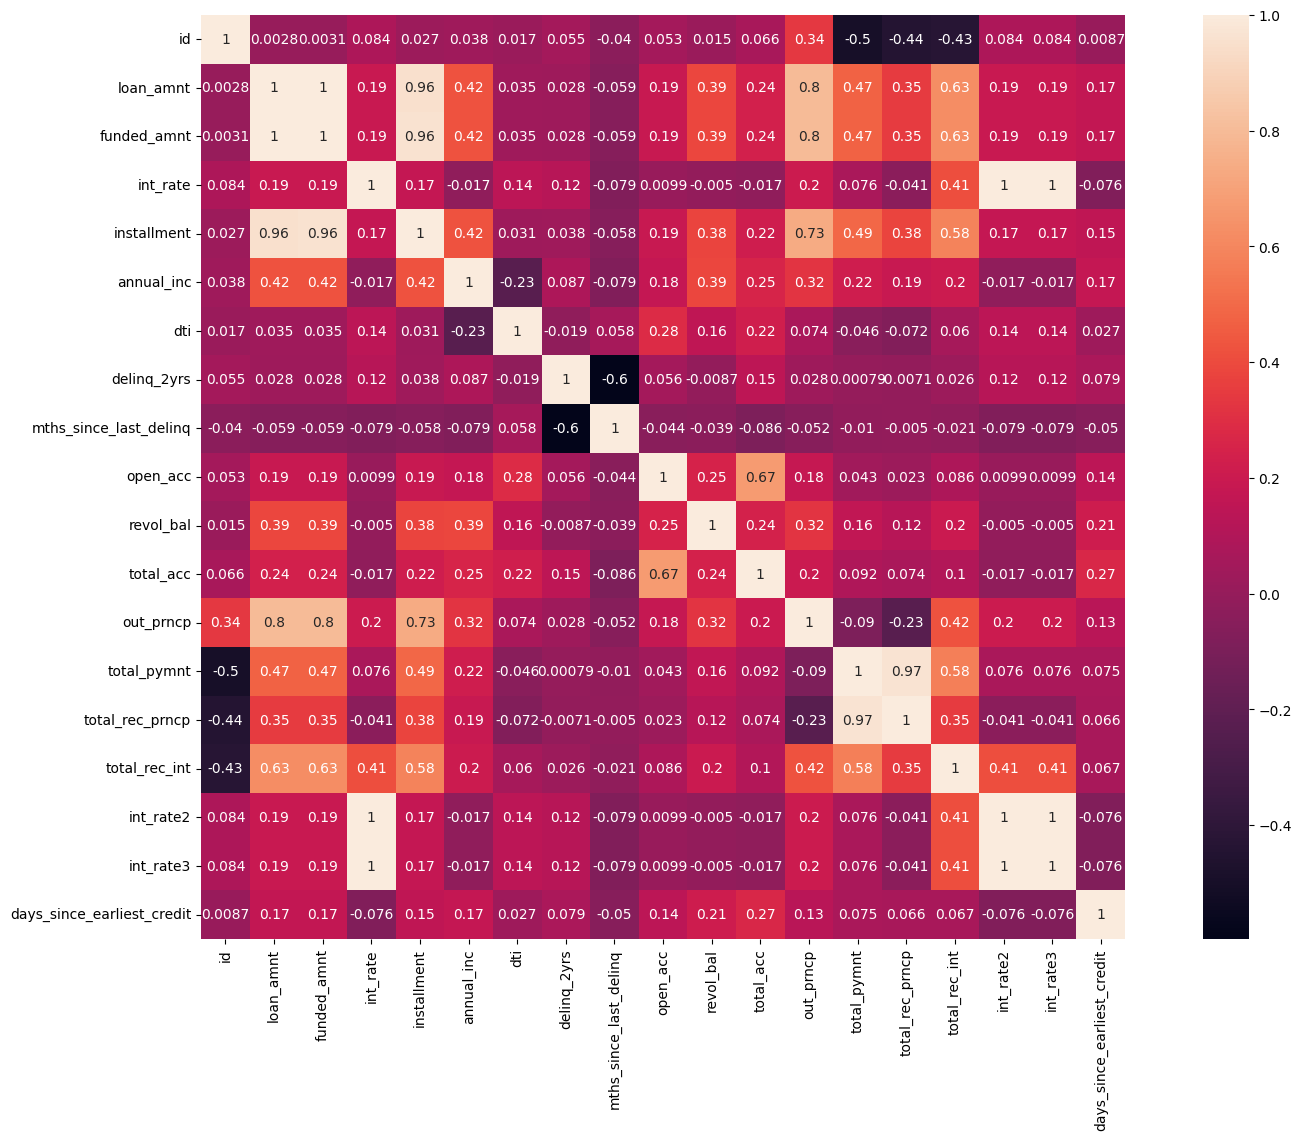

In [9]:

#Use the pearson correlation coefficient to determine how closely correlated the continuous numerical variables are with each other
cor_plot = loan_data.corr(method = 'pearson', numeric_only = True)
fig , ax = plt.subplots(figsize = (20,12))
sns.heatmap(cor_plot, square = True, annot = True)
cor_plot



#### Interest rates 2 and 3 are both perfectly correlated with interest rate and therefore interest 2 and 3 will be removed since they are
# not providing any information gain

loan_data = loan_data.drop(["int_rate2","int_rate3", "funded_amnt"], axis = 1)


Missing Value Imputation

In [10]:

#find the percentage of the total data that is missing
(loan_data.isnull().sum() / len(loan_data)) * 100


id                             0.00
loan_amnt                      0.00
funded_amnt                    0.00
term                           4.76
int_rate                       4.76
installment                    4.76
emp_length                     8.81
home_ownership                 4.76
annual_inc                     4.76
loan_status                    4.76
purpose                        4.76
addr_state                     0.00
dti                            4.76
delinq_2yrs                    4.76
mths_since_last_delinq        59.00
open_acc                       4.76
revol_bal                      4.76
total_acc                      4.76
out_prncp                      4.76
total_pymnt                    4.76
total_rec_prncp                4.76
total_rec_int                  4.76
int_rate2                      4.76
int_rate3                      4.76
days_since_earliest_credit     4.77
dtype: float64

##### Note: Months since last deliquency has about 59% of observations missing. his could either be from true missing data, or if the borrower has never been delinquent, then the correct value should be 0. But looking at the pearson correlation coefficient for the two variables does not reveal a correlation.


In [11]:
# remove variables where over 55% of the values are missing 
loan_data = loan_data.drop("mths_since_last_delinq", axis = 1)


In [13]:

#remove observations in which at least 19 of 21 variables missing
loan_cleaned = loan_data.dropna(thresh = 19, axis = 0)
loan_cleaned

#This leaves 9524 observations which is about 95% of the original number of observations


,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,...,open_acc,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,int_rate2,int_rate3,days_since_earliest_credit
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,72804.0,Current,...,21.0,8751.0,49.0,13263.18,7273.77,4736.82,2536.95,10.16,10.16,10192.0
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,100000.0,Current,...,16.0,20650.0,45.0,15294.25,496.78,380.75,116.03,8.90,8.90,10820.0
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,42000.0,Late (31-120 days),...,9.0,2229.0,17.0,12966.64,5000.85,3533.36,1467.49,7.90,7.90,11086.0
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,55000.0,Fully Paid,...,17.0,9486.0,25.0,0.00,5792.14,5500.00,292.14,13.67,13.67,13269.0
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,34000.0,Current,...,6.0,4915.0,15.0,4430.59,2912.26,1969.41,942.85,15.80,15.80,9383.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745,10121901,12000,12000,36 months,14.47,412.88,10+ years,MORTGAGE,73000.0,Current,...,12.0,9217.0,21.0,11731.82,412.88,268.18,144.70,14.47,14.47,8782.0
9746,10122303,17000,17000,36 months,6.62,521.97,10+ years,MORTGAGE,51000.0,Current,...,8.0,529.0,26.0,16573.46,519.96,426.54,93.42,6.62,6.62,12038.0
9747,10122772,10600,10600,36 months,18.25,384.55,10+ years,RENT,50295.0,Fully Paid,...,17.0,8984.0,28.0,0.00,10761.22,10600.00,161.22,18.25,18.25,9507.0
9748,10123620,15000,15000,36 months,13.53,509.25,10+ years,MORTGAGE,40000.0,Current,...,16.0,12632.0,46.0,14660.87,507.76,339.13,168.63,13.53,13.53,12066.0


In [14]:

#create a function to find the median of a column
def arr_median(num_array):
    arr_len = len(num_array)
    sorted_arr = np.sort(num_array)
    if arr_len % 2 == 0:
        med_arr = (sorted_arr[int((arr_len-1) / 2)] + sorted_arr[int(arr_len / 2)])/2
        return(int(med_arr))
    else:
        med_arr = sorted_arr[int((arr_len-1) / 2)]
        return(int(med_arr))
        
arr_median(loan_cleaned["days_since_earliest_credit"])


9043

After the clean-up there is still two variable with missing values and that is emp_length (length of employment). For times sake. This variable will be imputed using the value of the mode for the variable. And days_since_earliest_credit will be imputed with the median column value.

In [15]:

#use imputation for the remaining variables with missing values.
loan_cleaned.loc[:,"emp_length"] = loan_cleaned["emp_length"].fillna(loan_cleaned["emp_length"].mode()[0]) #impute with the mode
loan_cleaned.loc[:,"days_since_earliest_credit"] = loan_cleaned["days_since_earliest_credit"].fillna(arr_median(loan_cleaned["days_since_earliest_credit"])) #impute with the median

#ensure all of the missing values have been handled either by imputation or removal
(loan_data.isnull().sum() / len(loan_data)) * 100


id                            0.00
loan_amnt                     0.00
funded_amnt                   0.00
term                          4.76
int_rate                      4.76
installment                   4.76
emp_length                    8.81
home_ownership                4.76
annual_inc                    4.76
loan_status                   4.76
purpose                       4.76
addr_state                    0.00
dti                           4.76
delinq_2yrs                   4.76
open_acc                      4.76
revol_bal                     4.76
total_acc                     4.76
out_prncp                     4.76
total_pymnt                   4.76
total_rec_prncp               4.76
total_rec_int                 4.76
int_rate2                     4.76
int_rate3                     4.76
days_since_earliest_credit    4.77
dtype: float64

### Handling Outliers



In [16]:

#Handle Outliers
# find the exact values of the outliers using the interquantile range
numerical_cols = list(loan_cleaned.select_dtypes(exclude = "object").columns) #create a list for the continuous numerical variables

def iqr_column_bounds(dataframe, column):
    q_1, q_3 = np.percentile(loan_cleaned[column], [25,75])
    #print(q_1, q_3)
    iqr = q_3 - q_1
    lower_bound = q_1 - (1.5 * iqr)
    upper_bound = q_3 + (1.5 * iqr)
    outlier_vals = (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)
    return(dataframe[column].loc[outlier_vals])

#create a dictionary to store the values and the indexes of all of the outliers by column
outlier_dict = {} 
for column in numerical_cols:
    outlier_dict[column] = iqr_column_bounds(loan_cleaned, column)




In [17]:

#create a list of the columns that habe outliers as determined by the IQR
outlier_list = []
for key, value in outlier_dict.items():
    if value.empty != True:
        outlier_list.append(key)
        # use the results of the skew to determine if additional transformations need to be applied to the variables with non-normal distributions
        var_skew = float(loan_cleaned[key].skew())
        print(key + " Skew Before Transformation :" + str(var_skew))
        #if the skew is greater than 1 or less than -1, perform a log transformation on the variable
        if (var_skew < -1.5) | (var_skew > 1.5):
            loan_cleaned[key] = loan_cleaned[key].map(lambda i: np.log(i) if i > 0 else 0)
            print(key + " Skew After Transformation :" + str(loan_cleaned[key].skew()))

        

installment Skew Before Transformation :0.9320047875434381
annual_inc Skew Before Transformation :5.006879478282269
annual_inc Skew After Transformation :0.2092524315605634
delinq_2yrs Skew Before Transformation :4.94446179743907
delinq_2yrs Skew After Transformation :5.37093587119928
open_acc Skew Before Transformation :0.9352230577138988
revol_bal Skew Before Transformation :5.6083161605099665
revol_bal Skew After Transformation :-2.8786924329462114
total_acc Skew Before Transformation :0.7221528984225445
out_prncp Skew Before Transformation :0.7859300330164416
total_pymnt Skew Before Transformation :2.552874967523885
total_pymnt Skew After Transformation :-0.30372573139855724
total_rec_prncp Skew Before Transformation :3.071417938640482
total_rec_prncp Skew After Transformation :-0.1549845485529628
total_rec_int Skew Before Transformation :2.5963065330566524
total_rec_int Skew After Transformation :-0.34220634128141036
days_since_earliest_credit Skew Before Transformation :-1.315374

### Target Variable Creation

In [18]:
# use the levels of the loan_status variable as the basis for creating a target variable 
loan_cleaned["loan_status"].value_counts()

loan_status
Current               8122
Fully Paid             951
Charged Off            218
Late (31-120 days)     148
In Grace Period         48
Late (16-30 days)       21
Default                 16
Name: count, dtype: int64

In [19]:
# recode the loan_status variable into a binary good/bad loan variable
loan_cleaned["good_bad_loan"] = np.where((loan_cleaned["loan_status"] == "Fully Paid") | (loan_cleaned["loan_status"] == "Current"), 1, 0)
loan_final = loan_cleaned.drop(["loan_status"], axis = 1) #remove the original loan status variable
loan_final.head()


,id,loan_amnt,funded_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,purpose,...,revol_bal,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,int_rate2,int_rate3,days_since_earliest_credit,good_bad_loan
0,571203,18000,18000,60 months,10.16,383.87,10+ years,MORTGAGE,11.195526,credit_card,...,9.076923,49.0,13263.18,8.892030,8.463121,7.838718,10.16,10.16,10192.0,1
1,694891,15675,15675,36 months,8.90,497.74,10+ years,MORTGAGE,11.512925,small_business,...,9.935471,45.0,15294.25,6.208147,5.942143,4.753849,8.90,8.90,10820.0,1
2,784712,16500,16500,60 months,7.90,333.78,2 years,MORTGAGE,10.645425,small_business,...,7.709308,17.0,12966.64,8.517363,8.170005,7.291309,7.90,7.90,11086.0,0
3,843448,5500,5500,36 months,13.67,187.10,3 years,RENT,10.915088,debt_consolidation,...,9.157572,25.0,0.00,8.664257,8.612503,5.677233,13.67,13.67,13269.0,1
4,974654,6400,6400,36 months,15.80,224.38,2 years,RENT,10.434116,debt_consolidation,...,8.500047,15.0,4430.59,7.976685,7.585489,6.848907,15.80,15.80,9383.0,1


In [20]:

# review the balance of the response variable
loan_final['good_bad_loan'].value_counts()


good_bad_loan
1    9073
0     451
Name: count, dtype: int64

Text(0.5, 1.0, 'Term Counts by Good and Bad Loans')

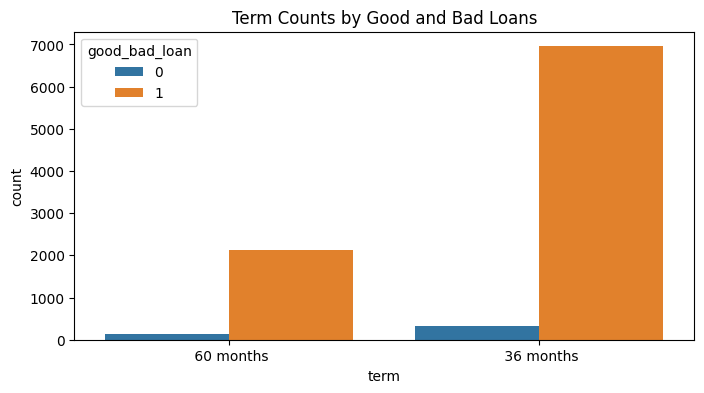

In [21]:
#plot the categorical variables against the good/bad loan indicator

plt.figure(figsize = (8,4))
sns.countplot(x = "term", hue = "good_bad_loan", data = loan_final).set_title("Term Counts by Good and Bad Loans")


Text(0.5, 1.0, 'Term Counts by Good and Bad Loans')

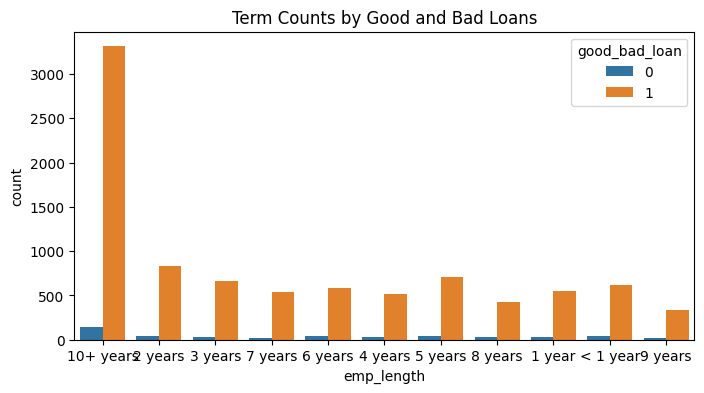

In [22]:
plt.figure(figsize = (8,4))
sns.countplot(x = "emp_length", hue = "good_bad_loan", data = loan_final).set_title("Term Counts by Good and Bad Loans")


Text(0.5, 1.0, 'Good and Bad Loans by Home Ownership Status')

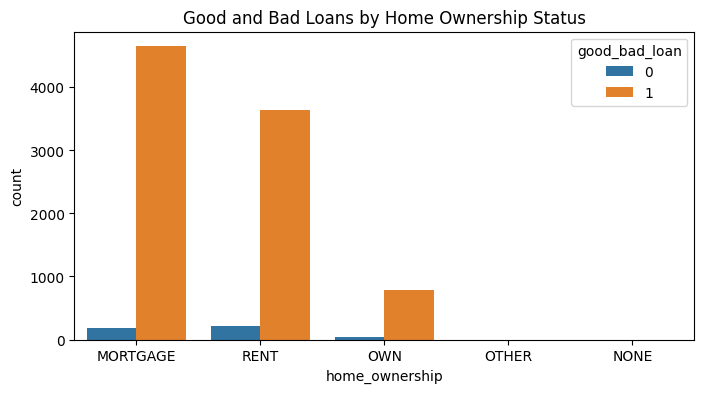

In [23]:
plt.figure(figsize = (8,4))
sns.countplot(x = "home_ownership", hue = "good_bad_loan", data = loan_final).set_title("Good and Bad Loans by Home Ownership Status")


Text(0.5, 1.0, 'Good and Bad Loans by Loan Purpose')

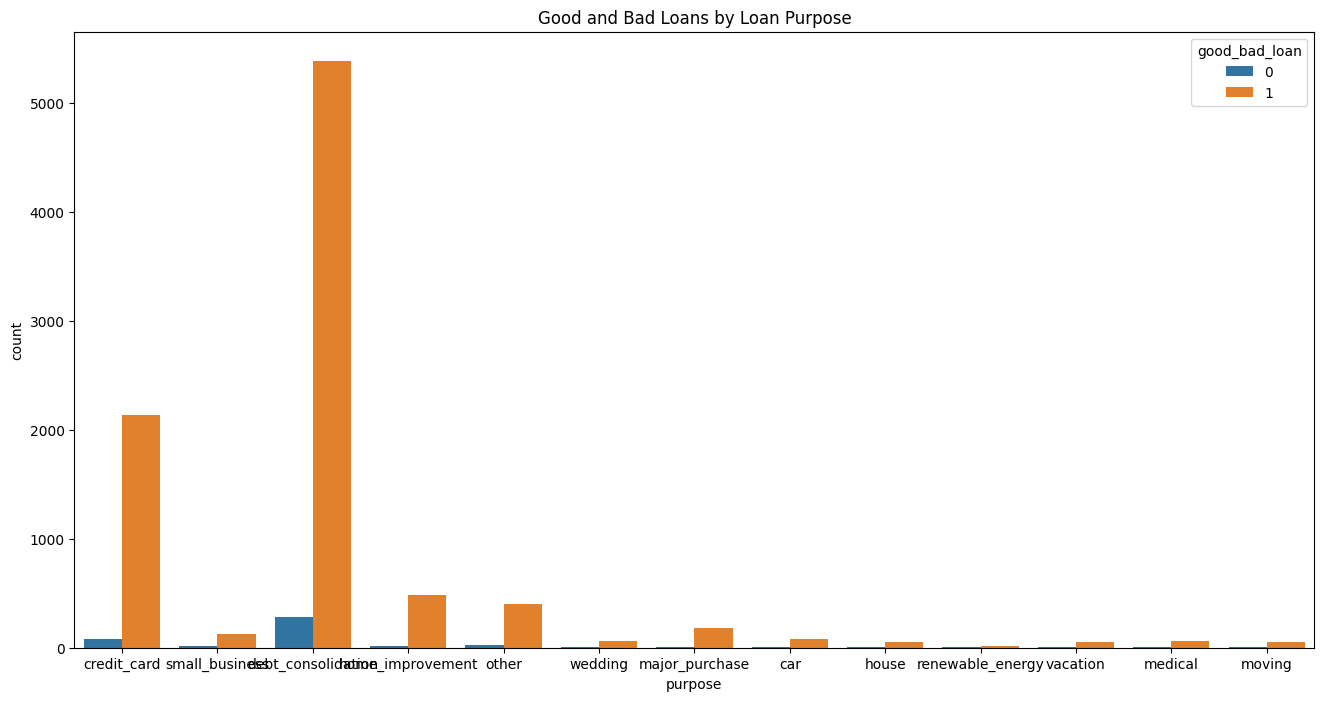

In [24]:

plt.figure(figsize = (16,8))
sns.countplot(x = "purpose", hue = "good_bad_loan", data = loan_final).set_title("Good and Bad Loans by Loan Purpose")


In [25]:

# scale continuous numeric variables, encode categorical and ordinal variables
cat_col_list = list(loan_final.select_dtypes(include = "object").columns) # list of column names of categorical variables
cat_col_list.remove("emp_length") # remove employment length as it is ordinal and will be encoded differently
num_col_list = list(loan_final.iloc[:,1:-1].select_dtypes(exclude = "object").columns) # list of column names of continuous numeric variables

#initialize categorical encoder
one_hot = OneHotEncoder(sparse = False)
for col in cat_col_list:
    loan_final[col] = one_hot.fit_transform(loan_final[col].values.reshape(-1,1))

#initialize scaler encoder
scaler = StandardScaler()
for col in num_col_list:
    loan_final[col] = scaler.fit_transform(loan_final[col].values.reshape(-1,1))

#initialize ordinal encoder with labels in ascedning order
ordinal_encoder = OrdinalEncoder(categories = [['< 1 year', '1 year','2 years', '3 years', '4 years','5 years','6 years','7 years', '8 years','9 years', '10+ years']])
loan_final['emp_length'] = ordinal_encoder.fit_transform(loan_final['emp_length'].values.reshape(-1,1))



### Training and Testing Split

In [26]:
# alias data, split the response and the feature set
feature_set = loan_final.iloc[:,1:-1]
response_var = pd.factorize(loan_final.iloc[:,-1])[0].reshape(-1,1)


In [27]:

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    feature_set, response_var, random_state = 127, test_size = .30)


In [28]:
# Due to the imbalanced nature of the dataset, the "good" loan observations will be downsampled

#define the undersampling scheme
undersampling_scheme = RandomUnderSampler(sampling_strategy = 'majority') #downsample from the majority (good loans)
#transform the training data with the downsampling scheme
x_train_down, y_train_down = undersampling_scheme.fit_resample(x_train, y_train) # resample and denote new training sets
x_test_down, y_test_down = undersampling_scheme.fit_resample(x_test, y_test)

### Modeling

In [29]:

# a function that will produce thee outputs of a grid search for random forest and xgboost models
def grid_search_models(model_name, x_train_df, y_train_df, num_estimators_per_param, random_state): 
    if str(model_name).lower() in ("random forest","random_forest"):
        grid = {'n_estimators': [n for n in range(100,1000,100)[0: num_estimators_per_param]], # since the number of values to grid searh per parameter increases processing time, the "num_estimators_per_param" parameter denotes how many intervals of each parameter to test
              'max_depth': [n for n in range(10,100,10)[0: num_estimators_per_param]],
              'min_samples_split': [n for n in range(2,20,2)[0: num_estimators_per_param]],
              'min_samples_leaf':[n for n in range(2,20,2)[0: num_estimators_per_param]]}
        rf_grid_search = GridSearchCV(RandomForestClassifier(random_state = random_state), param_grid = grid,
                          cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state), scoring = 'f1') # random forest grid search
        rf_grid_search.fit(x_train_df, y_train_df) # fit the training features and target variable to the grid search
        return(rf_grid_search.best_params_) # return the values of the most optimally tuned parameters
    if str(model_name).lower() in ("xg boost", "xgboost", "xg_boost"):
        grid = {'n_estimators': [n for n in range(500,2000,500)[0: num_estimators_per_param]],
              'min_child_weight': [n for n in range(1,10,1)[0: num_estimators_per_param]],
              'max_depth': [n for n in range(1,10,1)[0: num_estimators_per_param]]}
        xgb_grid_search = GridSearchCV(XGBClassifier(random_state = random_state), param_grid = grid,
                          cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state), scoring = 'f1')
        xgb_grid_search.fit(x_train_df, y_train_df)
        return(xgb_grid_search.best_params_)
    



In [30]:

# a function that runs logistic regression, random forest, and xgboost model and produces their model evaluation metrics 
def build_models(model_name, x_train_data, y_train_data, x_test_data, y_test_data, random_state, num_estimators_per_param):
   
    if str(model_name).lower() in ("logistic","logistic_regression"):
        classifier = LogisticRegression(random_state = random_state, penalty = "l2", class_weight = 'balanced')
    if str(model_name).lower() in ("random forest","random_forest"):
        rf_params = grid_search_models(model_name,  x_train_data, y_train_data, num_estimators_per_param, random_state)
        classifier = RandomForestClassifier(n_estimators = rf_params['n_estimators'] , max_depth = rf_params['max_depth'], min_samples_split = 5, min_samples_leaf = 2, random_state = random_state)
    if str(model_name).lower() in ("xg boost", "xgboost", "xg_boost"):
        xgb_params = grid_search_models(model_name, x_train_data, y_train_data, num_estimators_per_param, random_state)
        classifier = XGBClassifier(n_estimators = xgb_params['n_estimators'], min_child_weight = xgb_params['min_child_weight'], max_depth = xgb_params['max_depth'])
    #fit the classifier to the training data
    classifier.fit(x_train_data, y_train_data)
    
    #predict using the test data on the logistic model
    model_predictions = classifier.predict(x_test_data)
    # evaluation metrics
    model_accuracy = accuracy_score(y_test_data, model_predictions)
    class_score = classification_report(y_test_data, model_predictions)
    roc = roc_auc_score(y_test_data, model_predictions)
    print(model_name + " Accuracy Measure: " + str(model_accuracy))
    print(model_name + " Classification Report: \n")
    print(class_score)
    print(model_name + " ROC Score: " + str(roc))
    print(" ")

    #plot roc curve
    classifier_probs = classifier.predict_proba(x_test_data)[:, 1:]
    false_pos_rate, true_pos_rate, _ = roc_curve(y_test_data, classifier_probs)
    auc_classifier = roc_auc_score(y_test_data, classifier_probs)
    plt.plot(false_pos_rate, true_pos_rate, label = f"model_name, AUC = {str(auc_classifier)}")
    plt.show

    #visualize the confusion matrix
    c_matrix = confusion_matrix(y_test_data, model_predictions)
    sns.heatmap(c_matrix/np.sum(c_matrix), annot = True, cmap = 'Blues')



### Regularly Sampled Results

In [ ]:
#build the models for the regularly sampled data
model_list = ["logistic_regression", "random_forest", "xg_boost"]
for model in model_list:
    plt.figure(figsize = (16,10))
    build_models(model, x_train, y_train, x_test, y_test, 27, 2)


logistic_regression Accuracy Measure: 0.8271518544436669
logistic_regression Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      2718
           1       0.17      0.68      0.28       140

    accuracy                           0.83      2858
   macro avg       0.58      0.76      0.59      2858
weighted avg       0.94      0.83      0.87      2858

logistic_regression ROC Score: 0.7566882161253022
 


### Downsampled Results

In [ ]:

# the model run with the data downsampled from the majority ("good") class
for model in model_list:
    plt.figure(figsize = (16,10))
    build_models(model, x_train_down, y_train_down, x_test_down, y_test_down, 27, 2)

